In [251]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt

## Moon Dataset

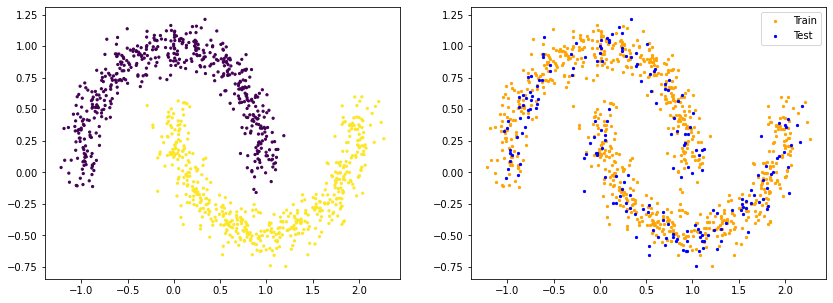

In [252]:
# create dataset
from sklearn.datasets import make_moons

n_samples = 1000
X, y = make_moons(n_samples, noise=0.1, random_state=42)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# split the data
np.random.seed(42)
train_size = int(0.8 * len(X))
random_index = np.random.permutation(len(X))
X_train, y_train = X[random_index[:train_size]], y[random_index[:train_size]]
X_test, y_test = X[random_index[train_size:]], y[random_index[train_size:]]

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c=y, s=5)

plt.subplot(1,2,2)
plt.scatter(X_train[:,0], X_train[:,1], c='orange', s=5, label='Train')
plt.scatter(X_test[:,0], X_test[:,1], c='blue', s=5, label='Test')
plt.legend();

In [253]:
# build Model
class MoonClassification(nn.Module) :
    def __init__(self) :
        super().__init__()

        self.input_layer = nn.Linear(2,10)
        self.hidden_l1 = nn.Linear(10,10)
        self.hidden_l2 = nn.Linear(10,10)
        self.output_layer = nn.Linear(10,1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x) :
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.hidden_l1(x)
        x = self.relu(x)
        x = self.hidden_l2(x)
        x = self.relu(x)
        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x

model_v0 = MoonClassification()
model_v0

MoonClassification(
  (input_layer): Linear(in_features=2, out_features=10, bias=True)
  (hidden_l1): Linear(in_features=10, out_features=10, bias=True)
  (hidden_l2): Linear(in_features=10, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [254]:
# setup Loss and Optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model_v0.parameters(), lr=0.4)

# setup accuracy function
def acc_fn(y_true, y_pred) :
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_true)
    return acc*100

In [256]:
torch.manual_seed(42)

epochs = 150
for epoch in range(epochs) :
    model_v0.train()
    y_logits = model_v0(X_train).squeeze()
    y_pred = torch.round(y_logits) # 0 or 1

    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_train, y_pred)
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    model_v0.eval()
    with torch.inference_mode() :
        test_logits = model_v0(X_test).squeeze()
        test_pred = torch.round(test_logits) # 0 or 1

        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(y_test, test_pred)

    if epoch % 10 == 0 or (epoch+1) == epochs :
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.22113, Accuracy: 88.62% | Test Loss: 0.22088, Test Accuracy: 87.00%
Epoch: 10 | Loss: 0.22005, Accuracy: 88.62% | Test Loss: 0.22112, Test Accuracy: 87.50%
Epoch: 20 | Loss: 0.22450, Accuracy: 89.38% | Test Loss: 0.23508, Test Accuracy: 88.00%
Epoch: 30 | Loss: 0.27880, Accuracy: 89.62% | Test Loss: 0.30218, Test Accuracy: 85.50%
Epoch: 40 | Loss: 0.22227, Accuracy: 89.50% | Test Loss: 0.22498, Test Accuracy: 87.50%
Epoch: 50 | Loss: 0.21795, Accuracy: 88.75% | Test Loss: 0.21859, Test Accuracy: 87.50%
Epoch: 60 | Loss: 0.21560, Accuracy: 88.88% | Test Loss: 0.21675, Test Accuracy: 88.00%
Epoch: 70 | Loss: 0.21345, Accuracy: 89.62% | Test Loss: 0.22045, Test Accuracy: 88.00%
Epoch: 80 | Loss: 0.24146, Accuracy: 90.50% | Test Loss: 0.26768, Test Accuracy: 86.50%
Epoch: 90 | Loss: 0.18365, Accuracy: 92.38% | Test Loss: 0.18477, Test Accuracy: 90.50%
Epoch: 100 | Loss: 0.14555, Accuracy: 95.00% | Test Loss: 0.14642, Test Accuracy: 93.00%
Epoch: 110 | Loss: 0.13503, Accu

In [257]:
# prediction 
model_v0.eval()
with torch.inference_mode() :
    y_train_logits = model_v0(X_train)
    y_test_logits = model_v0(X_test)

y_test_logits[:5]

tensor([[0.0023],
        [0.9996],
        [0.0657],
        [0.9961],
        [0.9488]])

In [258]:
y_train_preds = torch.round(y_train_logits).reshape(-1,)
y_test_preds = torch.round(y_test_logits).reshape(-1,)
y_test_preds[:5]

tensor([0., 1., 0., 1., 1.])

In [259]:
y_train.ndim

1

In [312]:
def plot_decistion_bounary(model, resolution, X, y) :
    x_min, x_max = X[:,0].min()-0.1, X[:,1].max()+0.1
    y_min, y_max = X[:,0].min()-0.1, X[:,1].max()+0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution), np.linspace(y_min, y_max, resolution))

    x_new = np.c_[xx.ravel(), yy.ravel()]
    x_new = torch.from_numpy(x_new).type(torch.float)
    
    model.eval()
    with torch.inference_mode() :
        y_logits = model(x_new) # prediction
        if y_logits[0].shape[-1] == 1: # binary classification # 0 or 1
            y_preds = torch.round(y_logits)                        
        else :
            y_preds = torch.argmax(y_logits, dim=1)

    
    y_preds = torch.reshape(y_preds, (xx.shape))

    plt.contourf(xx, yy, y_preds, alpha=0.5, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:,0], X[:,1], c=y, s=5, cmap=plt.cm.RdYlBu)
    plt.xlabel('$X1$')
    plt.ylabel('$X2$')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

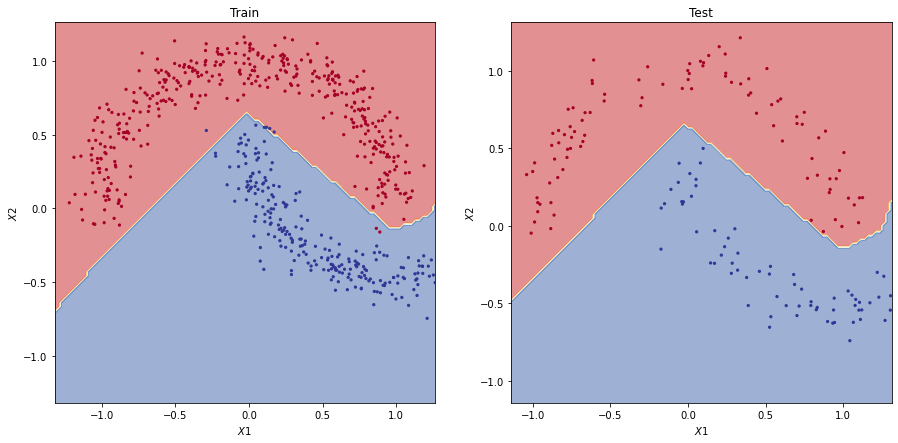

In [283]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plot_decistion_bounary(model_v0, 100, X_train, y_train)
plt.title('Train')

plt.subplot(1,2,2)
plot_decistion_bounary(model_v0, 100, X_test, y_test)
plt.title('Test');

## Spiral Dataset

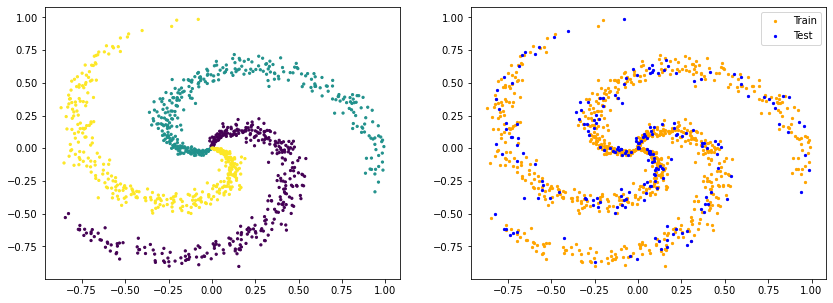

In [284]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 350 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# split the data
np.random.seed(42)
train_size = int(0.8 * len(X))
random_index = np.random.permutation(len(X))
X_train, y_train = X[random_index[:train_size]], y[random_index[:train_size]]
X_test, y_test = X[random_index[train_size:]], y[random_index[train_size:]]

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c=y, s=5)

plt.subplot(1,2,2)
plt.scatter(X_train[:,0], X_train[:,1], c='orange', s=5, label='Train')
plt.scatter(X_test[:,0], X_test[:,1], c='blue', s=5, label='Test')
plt.legend();
plt.show()

In [299]:
# build Model
class SpiralClassification(nn.Module) :
    def __init__(self, num_class) :
        super().__init__()

        self.input_layer = nn.Linear(2, 10)
        self.hidden_l1 = nn.Linear(10,20)
        self.hidden_l2 = nn.Linear(20,20)
        self.hidden_l2 = nn.Linear(20,20)
        self.hidden_l3 = nn.Linear(20,20)
        self.output_layer = nn.Linear(20,num_class)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x) :
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.hidden_l1(x)
        x = self.relu(x)
        x = self.hidden_l2(x)
        x = self.relu(x)
        x = self.hidden_l3(x)
        x = self.relu(x)
        x = self.output_layer(x)
        x = self.softmax(x)
        return x

model_v1 = SpiralClassification(num_class=3)
model_v1

SpiralClassification(
  (input_layer): Linear(in_features=2, out_features=10, bias=True)
  (hidden_l1): Linear(in_features=10, out_features=20, bias=True)
  (hidden_l2): Linear(in_features=20, out_features=20, bias=True)
  (hidden_l3): Linear(in_features=20, out_features=20, bias=True)
  (output_layer): Linear(in_features=20, out_features=3, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [324]:
# setup Loss and Optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_v1.parameters(), lr=0.002)

In [325]:
# train the model
epochs = 250

for epoch in range(epochs) :
    model_v1.train()

    y_logits = model_v1(X_train)
    y_pred = torch.argmax(y_logits, dim=1)
    loss = loss_fn(y_logits, y_train.type(torch.LongTensor))
    acc = acc_fn(y_train, y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_v1.eval()
    with torch.inference_mode() :
        test_logits = model_v1(X_test)
        test_pred = torch.argmax(test_logits, dim=1)
        test_loss = loss_fn(test_logits, y_test.type(torch.LongTensor))
        test_acc = acc_fn(y_test, test_pred)

    if epoch % 25 == 0 or (epoch+1) == epochs :
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.55586, Accuracy: 99.52% | Test Loss: 0.57037, Test Accuracy: 97.62%
Epoch: 25 | Loss: 0.55586, Accuracy: 99.52% | Test Loss: 0.56682, Test Accuracy: 98.57%
Epoch: 50 | Loss: 0.55584, Accuracy: 99.52% | Test Loss: 0.56547, Test Accuracy: 98.57%
Epoch: 75 | Loss: 0.55583, Accuracy: 99.52% | Test Loss: 0.56516, Test Accuracy: 98.57%
Epoch: 100 | Loss: 0.55582, Accuracy: 99.52% | Test Loss: 0.56399, Test Accuracy: 98.57%
Epoch: 125 | Loss: 0.55582, Accuracy: 99.52% | Test Loss: 0.56296, Test Accuracy: 99.05%
Epoch: 150 | Loss: 0.55581, Accuracy: 99.52% | Test Loss: 0.56207, Test Accuracy: 99.05%
Epoch: 175 | Loss: 0.55581, Accuracy: 99.52% | Test Loss: 0.56187, Test Accuracy: 99.05%
Epoch: 200 | Loss: 0.55581, Accuracy: 99.52% | Test Loss: 0.56180, Test Accuracy: 99.05%
Epoch: 225 | Loss: 0.55580, Accuracy: 99.52% | Test Loss: 0.56180, Test Accuracy: 99.05%
Epoch: 249 | Loss: 0.55580, Accuracy: 99.52% | Test Loss: 0.56176, Test Accuracy: 99.05%


In [326]:
# prediction 
model_v1.eval()
with torch.inference_mode() :
    y_train_logits = model_v1(X_train)
    y_test_logits = model_v1(X_test)

y_test_logits[:5]

tensor([[4.8182e-16, 1.0000e+00, 0.0000e+00],
        [1.4260e-16, 1.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.0456e-15, 2.9475e-19],
        [3.5988e-14, 1.0000e+00, 5.7818e-13],
        [5.9592e-11, 1.0000e+00, 9.0916e-15]])

In [327]:
y_train_preds = torch.argmax(y_train_logits, dim=1).reshape(-1,)
y_test_preds = torch.argmax(y_test_logits, dim=1).reshape(-1,)
y_test_preds[:5]

tensor([1, 1, 0, 1, 1])

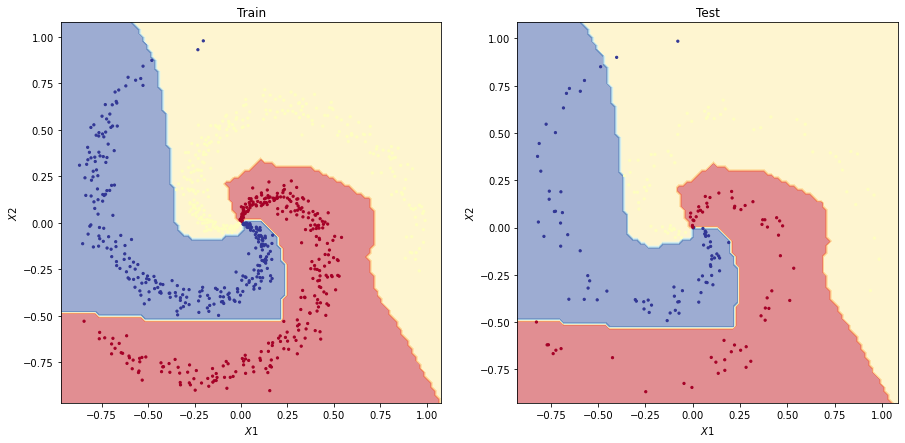

In [328]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plot_decistion_bounary(model_v1, 100, X_train, y_train)
plt.title('Train')

plt.subplot(1,2,2)
plot_decistion_bounary(model_v1, 100, X_test, y_test)
plt.title('Test');